# Extração de Features e Construção do Modelo

### 1. Introdução a Extração de Features
- A extração de features é uma parte muito importante na análise e na identificação de relações entre diferentes elementos. Como já sabemos, os dados de áudio não podem ser compreendidos diretamente pelos modelos, então precisamos convertê-los para um formato inteligível, e é para isso que a extração de features é utilizada.


#### Com a taxa de amostragem e os dados do sinal, podemos realizar diversas transformações para extrair características valiosas do áudio. No entanto, neste projeto, não vamos aprofundar no processo de seleção de features para identificar quais são mais relevantes para o nosso dataset. Em vez disso, vamos extrair cinco features principais para treinar nosso modelo:
- **Zero Crossing Rate (ZCR):** Mede a taxa de mudanças de sinal no áudio, ou seja, quantas vezes ele cruza o eixo zero em um determinado intervalo de tempo. Essa feature é útil para distinguir sons percussivos e não percussivos.
- **Chroma STFT:** Representa a energia espectral em 12 bins correspondentes às notas da escala musical ocidental. Essa característica é útil para identificar padrões harmônicos no áudio.
- **MFCC (Mel-Frequency Cepstral Coefficients):** Converte a frequência do áudio para a escala mel, aproximando-se da percepção auditiva humana. É uma das features mais utilizadas em reconhecimento de fala e emoção.
- **RMS (Root Mean Square):** Mede a energia do sinal ao calcular a média quadrática das amplitudes do áudio. Essa feature ajuda a representar a intensidade do som.
- **Mel Spectrogram:** Representa a distribuição de energia do áudio em diferentes faixas de frequência na escala mel, capturando informações espectrais essenciais.

### 1.1. Importando as bibliotecas

In [26]:
import pandas as pd
import numpy as np

import pickle
import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### 1.2. Carregar o Dataframe da EDA 

In [27]:
data_path = "/home/joaopc/Documents/gago/trilha/miniprojeto2/data/ravdess_preprocessed.csv" 
df = pd.read_csv(data_path)

In [28]:
df

,Emotions,Path,Processed_Path
0,neutral,/home/joaopc/Documents/gago/trilha/miniprojeto...,/home/joaopc/Documents/gago/trilha/miniprojeto...
1,neutral,/home/joaopc/Documents/gago/trilha/miniprojeto...,/home/joaopc/Documents/gago/trilha/miniprojeto...
2,neutral,/home/joaopc/Documents/gago/trilha/miniprojeto...,/home/joaopc/Documents/gago/trilha/miniprojeto...
3,neutral,/home/joaopc/Documents/gago/trilha/miniprojeto...,/home/joaopc/Documents/gago/trilha/miniprojeto...
4,calm,/home/joaopc/Documents/gago/trilha/miniprojeto...,/home/joaopc/Documents/gago/trilha/miniprojeto...
...,...,...,...
1435,surprise,/home/joaopc/Documents/gago/trilha/miniprojeto...,/home/joaopc/Documents/gago/trilha/miniprojeto...
1436,surprise,/home/joaopc/Documents/gago/trilha/miniprojeto...,/home/joaopc/Documents/gago/trilha/miniprojeto...
1437,surprise,/home/joaopc/Documents/gago/trilha/miniprojeto...,/home/joaopc/Documents/gago/trilha/miniprojeto...
1438,surprise,/home/joaopc/Documents/gago/trilha/miniprojeto...,/home/joaopc/Documents/gago/trilha/miniprojeto...


### 2. Criando uma função para extração das features

##### Fizemos essa parte no notebook passado, então você pode copiar e colar o código das funções aqui, pois precisaremos delas:

In [29]:
def noise(data):
    noise_amp = 0.005 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

# Taking any example and checking for techniques.
path = np.array(df.Path)[1]
data, sample_rate = librosa.load(path)

##### Aqui você deve extrair essas features de fato... mais tarde você precisará delas :)

In [30]:
def extract_features(data, sample_rate): 
    result = np.array([])

    # Zero Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))

    # Chroma_stft
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=data, sr=sample_rate).T, axis=0) 
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0) 
    result = np.hstack((result, mfcc))

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0) 
    result = np.hstack((result, rms))

    # MelSpectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0) 
    result = np.hstack((result, mel))
    
    return result

def get_features(path):
    # Carregar áudio
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # Sem aumento de dados
    res1 = extract_features(data, sample_rate)  
    result = np.array(res1)

    # Com ruído
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)  
    result = np.vstack((result, res2))

    # Com alongamento e mudança de pitch
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate) 
    result = np.vstack((result, res3))
    
    return result

##### Rode as células abaixo

In [ ]:
X, Y = [], []
for path, emotion in zip(df['Path'], df['Emotions']):
    feature = get_features(path)
    # Appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [ ]:
len(X), len(Y), df.Path.shape

(4320, 4320, (1440,))

##### Agora você deverá salvar o csv de features (features.csv)

In [ ]:
# Definir o caminho correto para a pasta 'data' na raiz do projeto
data_dir = os.path.join(os.path.dirname(os.getcwd()), "data")
os.makedirs(data_dir, exist_ok=True)

# Caminho correto para salvar o CSV na pasta 'data' da raiz do projeto
csv_path = os.path.join(data_dir, "features.csv")

# Crie um DataFrame do pandas chamado Features usando a lista X.
# Adicione uma coluna 'labels' ao DataFrame usando a lista Y.
# Salve o DataFrame como um arquivo CSV no caminho definido, sem incluir o índice, definindo _index_=False
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv(csv_path, index=False)

print(f"O arquivo foi salvo em: {csv_path}")

O arquivo foi salvo em: /home/joaopc/Documents/gago/trilha/miniprojeto2/data/features.csv


### 2.1. Data Preparation (Preparação dos Dados)

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# Use OneHotEncoder para transformar o Y em uma representação binária categórica, necessária para problemas de classificação multiclasse
ohe = OneHotEncoder()
Y = ohe.fit_transform(Y.reshape(-1,1)).toarray()

In [ ]:
# Use train_test_split do scikit-learn para dividir X e Y em conjuntos de treino e teste
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
# Utilize StandardScaler do sklearn para normalizar as características de X
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
# Rode essa célula para deixar as dimensões certinhas com o modelo que iremos criar.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3456, 162, 1), (3456, 8), (864, 162, 1), (864, 8))

### 3. Model Training (Modelling)

#### O modelo que vamos usar é uma rede neural convolucional (CNN) projetada para processar os dados extraídos dos arquivos de áudio. Essa estrutura é ideal para capturar padrões espectrais, como variações de tom e intensidade. A CNN é composta por:
- Camadas Convolucionais (Conv1D): Extraem características do espectro do áudio.
- Camadas de Pooling (MaxPooling1D): Reduzem a dimensionalidade e capturam as informações mais relevantes.
- Dropout: Ajuda a evitar overfitting.
- Camada Flatten: Transforma os mapas de features em um vetor de entrada para a camada totalmente conectada.
- Camadas Densas (Dense): Realizam a classificação final usando a função de ativação softmax.

In [ ]:
# Dica: você pode olhar a documentação e ir seguindo o passo a passo arquitetônico para criar o modelo.

# Passo 1: Use Sequential() para criar o modelo como um contêiner linear.
# Passo 2: Adicione uma camada Conv1D com 256 filtros, kernel_size=5, strides=1, padding='same' e função de ativação 'relu'.
# Passo 3: Siga com uma camada MaxPooling1D com pool_size=5, strides=2, padding='same'.
# Passo 4: Adicione mais uma camada Conv1D com 256 filtros, kernel_size=5, strides=1, padding='same' e função de ativação 'relu'.
# Passo 5: Adicione mais uma camada MaxPooling1D com pool_size=5, strides=2, padding='same'.
# Passo 6: Adicione mais uma camada Conv1D com 128 filtros, kernel_size=5, strides=1, padding='same' e função de ativação 'relu'.
# Passo 7: Adicione mais uma camada MaxPooling1D com pool_size=5, strides=2, padding='same'.
# Passo 8: Adicione uma camada Dropout com 0.2 de taxa de dropout.
# Passo 9: Adicione mais uma camada Conv1D com 64 filtros, kernel_size=5, strides=1, padding='same' e função de ativação 'relu'.
# Passo 10: Adicione mais uma camada MaxPooling1D com pool_size=5, strides=2, padding='same'.
# Passo 11: Adicione uma camada Flatten.
# Passo 12: Adicione uma camada Dense com 32 unidades e função de ativação 'relu'.
# Passo 13: Adicione uma camada Dropout com 0.3 de taxa de dropout.
# Passo 14: Adicione uma camada Dense com 8 unidades e função de ativação 'softmax'.
# Passo 15: Compile o modelo com otimizador 'adam', loss 'categorical_crossentropy' e métrica 'accuracy'.
# Passo 16: Use model.summary() para visualizar o modelo.

model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


E0000 00:00:1757902944.090103    9586 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1757902944.098377    9586 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 162, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 81, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 81, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 41, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 21, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 557,288 (2.13 MB)

 Trainable params: 557,288 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

### 3.1. Agora vamos de fato treinar o modelo, siga esses passos: 
##### 1. Use o callback para Ajustar a Taxa de Aprendizado 
##### ReduceLROnPlateau: Diminui a taxa de aprendizado quando uma métrica está estagnada.
   Parâmetros:
   - monitor='loss': Monitora a perda durante o treinamento.
   - factor=0.4: Reduz a taxa de aprendizado por este fator.
   - patience=2: Número de épocas sem melhora antes da redução.
   - min_lr=0.0000001: Limite mínimo para a taxa de aprendizado.
             
##### 2. Treine o Modelo 
##### Utilize model.fit para iniciar o treino da rede neural.
   Parâmetros:
   - x_train, y_train: Conjunto de dados de treino.
   - batch_size=64: Número de amostras por atualização de gradiente.
   - epochs=50: Número de vezes que o modelo treina em todo o conjunto de dados.
   - validation_data=(x_test, y_test): Conjunto de dados para validação durante o treino.
   - callbacks=[rlrp]: Lista de callbacks a serem aplicados durante o treino.
     

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=0.0000001)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])
model.save('best_model.h5')

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8678 - loss: 0.3701

ValueError: Invalid dtype: object

### 3.2. Avaliar e Visualizar a Performance do Modelo

##### Passo 1: Avaliando o Modelo
- **Precisão nos Dados de Teste**:
  - Use `model.evaluate(x_test, y_test)` para calcular a precisão do modelo no conjunto de teste.

##### Passo 2: Preparando os Gráficos
- **Definindo Épocas**:
  - Crie uma lista de épocas para o eixo x
- **Configurando o Layout do Gráfico**:
  - Use `fig, ax = plt.subplots(1, 2)` para criar dois gráficos lado a lado.

##### Passo 3: Plotando a Perda
- **Gráfico de Perda**:
  - Plote a perda de treino e teste:
    ```python
    ax[0].plot(epochs, train_loss, label='Training Loss')
    ax[0].plot(epochs, test_loss, label='Testing Loss')
    ```

##### Passo 4: Plotando a Precisão
- **Gráfico de Precisão**:
  - Plote a precisão de treino e teste:
    ```python
    ax[1].plot(epochs, train_acc, label='Training Accuracy')
    ax[1].plot(epochs, test_acc, label='Testing Accuracy')
    ```

##### Objetivos:
  - **Perda**: Ajuda a identificar se o modelo está treinando bem ou se há overfitting.
  - **Precisão**: Mostra o quão eficaz é o treinamento do modelo em acertar as previsões.


Accuracy of our model on test data:: 65.51%


Text(0.5, 0, 'Epochs')

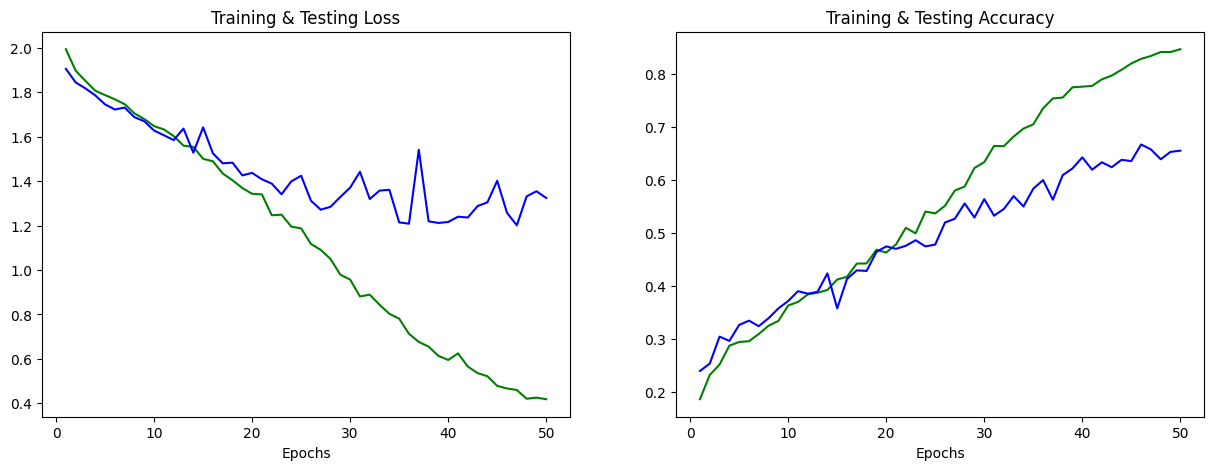

In [ ]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy of our model on test data:: {:.2f}%".format(acc * 100))

epochs = range(1, len(history.history['accuracy']) + 1)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(epochs, history.history['loss'], 'g', label='Training Loss')
ax[0].plot(epochs, history.history['val_loss'], 'b', label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].set_xlabel('Epochs')

ax[1].plot(epochs, history.history['accuracy'], 'g', label='Training Accuracy')
ax[1].plot(epochs, history.history['val_accuracy'], 'b', label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].set_xlabel('Epochs')

### 3.3. Chegou a parte boa! vamos prever os valores nos dados de teste
- Passo 1: Use model.predict() no x_test e salve o resultado em pred_test.
- Passo 2: Crie y_pred a partir de pred_test usando inverse_transform do encoder (Precisamos converter as previsões codificadas do One-Hot de volta aos rótulos originais)
- Passo 3: Faça o mesmo para os rótulos de teste (y_test), decodificando-os de volta aos rótulos originais.

In [ ]:
pred_test = model.predict(x_test)
y_pred = ohe.inverse_transform(pred_test)
y_test = ohe.inverse_transform(y_test)
    

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [ ]:
# Rode essa célula para ver se o modelo que criamos está fazendo sentido para a maioria dos valores.

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,angry,angry
1,fear,fear
2,disgust,disgust
3,sad,sad
4,disgust,surprise
5,surprise,surprise
6,happy,disgust
7,angry,angry
8,neutral,neutral
9,neutral,sad


### 3.4. Plotar Matriz de Confusão
- Agora tenho um desafio para você, eu quero que você crie uma matriz de confusão que relacione os resultados preditos com os valores reais das emoções!

Text(0.5, 80.7222222222222, 'Predicted Labels')

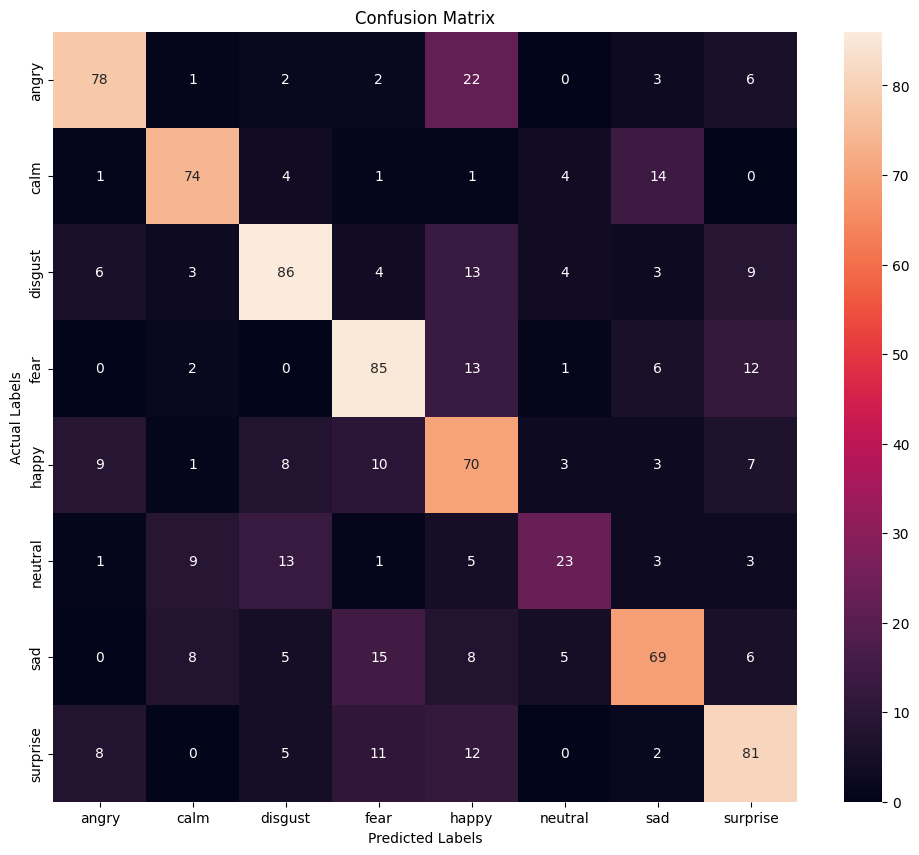

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=ohe.categories_[0], yticklabels=ohe.categories_[0])
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')

In [ ]:
# Use a função classification_report do sklearn para visualizar a precisão, recall e f1-score do modelo.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.76      0.68      0.72       114
        calm       0.76      0.75      0.75        99
     disgust       0.70      0.67      0.69       128
        fear       0.66      0.71      0.69       119
       happy       0.49      0.63      0.55       111
     neutral       0.57      0.40      0.47        58
         sad       0.67      0.59      0.63       116
    surprise       0.65      0.68      0.67       119

    accuracy                           0.66       864
   macro avg       0.66      0.64      0.64       864
weighted avg       0.66      0.66      0.66       864



### 4. Conclusão
- Podemos ver que nosso modelo é mais preciso na predição das emoções surpresa e raiva, o que faz sentido, pois os arquivos de áudio dessas emoções diferem bastante dos outros em aspectos como tom, velocidade, etc.
- No geral, alcançamos 62% de precisão nos dados de teste, o que é razoável, mas podemos melhorar ainda mais aplicando mais técnicas de aumento de dados e utilizando outros métodos de extração de features.

### 5. Salvando o Modelo e o Scaler

##### Passo 1: Salvando o Modelo
1. **Importação:** Use o `load_model` do Keras.
2. **Diretório:** Crie um diretório chamado `models` se não existir.
3. **Salvar:** Salve o modelo como no caminho especificado.

##### Passo 2: Salvando o Scaler
1. **Importação:** Use `joblib`.
2. **Diretório:** Utilize o mesmo caminho `models`.
3. **Salvar:** Salve o scaler.

In [ ]:
from keras.models import load_model
models_dir = "models"
os.makedirs(data_dir, exist_ok=True)

model_path = os.path.join(models_dir, "audio_emotion_model.keras")
model.save(model_path)

print(f"O modelo foi salvo em {model_path}")

O modelo foi salvo em models/audio_emotion_model.keras


In [ ]:
import joblib

scaler_path = os.path.join(models_dir, "scaler.pkl")
joblib.dump(scaler, scaler_path)
print(f"Scaler salvo em: {scaler_path}")

Scaler salvo em: models/scaler.pkl
